# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

### Resumen del problema

- Calcular los tópicos de portales de noticias que se reciben 
- Frecuencia del cálculo de tópicos: diaria
- Colección de noticias: diariamente, en lotes o de a un texto.
- Identificar tópicos, entidades, keywords y análisis de sentimiento.

### Datos
- Se reciben las noticias con formato: Titulo, Texto, Fecha, Entidades, Keywords

### Tareas
- Modelo de detección de tópicos diario utilizando embeddings
- Definir un criterio de agrupación de tópicos aplicado al mismo día y entre distintos días (merging)
- Almacenar los embeddings de tópicos en una base de datos vectorial
- Modelo de datos dado: 
    - Id del tópico
    - Nombre del tópico
    - Keywords
    - Embbeding
    - Fecha de creación
    - Fecha de entrenamiento inicial
    - Fecha de entrenamiento actualizada
    - Umbral de detección
    - Documento mas cercano
---
Tareas en esta notebook:
- Inicializar la base de datos vectorial
- Ingestar data
- NER: Encontrar las entidades de cada documento
- Limpiar data
- Modelo: Armado del modelo BERTopic
- Entrenamiento
- Almacenamiento en base de datos vectorial


### NLP_01_data
Esta notebook se utiliza para:
- obtener un lote predefinido de las noticias de una fecha dada
- se realiza el ejercicio de obtención de entities y keywords, mas allá de tenerlas provistas en el set de datos de origen.
- se obtiene el vocabulario para utilizar en BERTopic

Esta y las consecuentes notebooks son el desarrollo de base de procesos y funciones para la web app provista.

In [33]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import json
from datetime import datetime
from dateutil.parser import parse
from dotenv import load_dotenv
from tqdm import tqdm
from collections import Counter
from IPython.display import Image, display

import spacy

from NLP_tools import *

# -->> levantar la base antes de ejecutar
from opensearch_data_model import os_client
from opensearch_io import init_opensearch

from datasets import load_dataset

### Inicializamos la base vectorial
- Se modifica el indice de la base "Topic" agregando referencias del documento mas cercano como el ID y el titulo
- Se crea un nuevo indice para las noticias

In [34]:
# Inicialización de indices
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Path

In [35]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

### Obtenemos los datos 

In [36]:
# Ingestar noticias

# Desde Hugginface
date_choice = '2024-07-16'  # formato aaaa-mm-dd
path_file = f"jganzabalseenka/news_{date_choice}_24hs"
dataset = load_dataset(path_file)
df_parquet = pd.DataFrame(dataset['train'])

# Local """ el formato del archivo parque debe ser fecha aaaammdd "
# date_choice = '2024-07-15' 
# path_file = f"{date_choice}.parquet"
# df_parquet = pd.read_parquet(PATH+path_file)

df_parquet.head(1)

,asset_id,title_ch,Asset Destination,media,impact,start_time_utc,start_time_local,entities_curated,entities,predicted_at_entities,entities_raw_transformers,entities_transformers,title,text,keywords,predicted_at_keywords,truncated_text,title_and_text,prediction_delay_predictions,prediction_delay
0,114894323,Supremo recibe expediente de la Fiscalía colom...,http://infobae.com/america/agencias/2024/07/16...,Infobae,9642,2024-07-17 00:20:49,2024-07-16 21:20:49,"[Fiscalía General de la Nación Colombia, Alian...","[Iván Name, Julián Peinado Ramírez, Andrés Cal...",2024-07-17 00:59:39.937401,"[{'entities': [{'end': 7, 'entity_group': 'ORG...","[Supremo, Fiscalía colo, Newsroom Infobae Nuev...",Supremo recibe expediente de la Fiscalía colom...,"16 Jul, 2024 Por Newsroom Infobae Nuevo Bogot...","[los congresistas, fiscalía colombiana, falsed...",2024-07-17 01:05:59.174600,"16 Jul, 2024 Por Newsroom Infobae Nuevo Bogot...",Supremo recibe expediente de la Fiscalía colom...,0.105344,0.752826


In [37]:
# Cantidad total de documentos
len(df_parquet)

16037

### Validar datos para la fecha

In [38]:
choice = "".join(date_choice.split('-'))
df_parquet.sort_values("start_time_local", ascending=True, inplace=True)
df_date_filtered = df_parquet[df_parquet['start_time_local'].dt.date == pd.to_datetime(choice).date()]
print(f"Registros para la fecha {choice} -> {len(df_date_filtered)} de un total de {len(df_parquet)}")

Registros para la fecha 20240717 -> 11663 de un total de 16037


### Obtenemos un lote de N noticias por dia (para agilizar el procesamiento)

In [39]:
batch_news=os.environ.get('BATCH_NEWS', 1000)

df_batch = df_date_filtered.sample(n=int(batch_news)).reset_index()
data = list(df_batch['text'])
print(f"Batch: {len(data)}")
df_batch.head(1)

Batch: 1000


,index,asset_id,title_ch,Asset Destination,media,impact,start_time_utc,start_time_local,entities_curated,entities,...,entities_raw_transformers,entities_transformers,title,text,keywords,predicted_at_keywords,truncated_text,title_and_text,prediction_delay_predictions,prediction_delay
0,12314,114967809,Córdoba: más de 3.500 hectáreas fueron consumi...,http://canal13sanjuan.com/el-pais/2024/7/17/co...,Canal 13 San Juan,444,2024-07-17 16:48:19,2024-07-17 13:48:19,[],"[Schreiner, Daniel Soler Jamed Daniel Tejada N...",...,"[{'entities': [], 'text': ': más de 3.500 hect...","[Cerro Champaquí, Córdoba, Secretaría de Gesti...",Córdoba: más de 3.500 hectáreas fueron consumi...,Síganos! Los reportes oficiales publicados el ...,"[incendios forestales, hectáreas, cerro, vient...",2024-07-17 17:36:33.520650,Síganos! Los reportes oficiales publicados el ...,Córdoba: más de 3.500 hectáreas fueron consumi...,0.367204,0.804034


In [40]:
# Grabar a disco el dataframe filtrado 
df_batch.to_parquet(PATH+choice+".parquet")

### StopWords
Se genera una lista especial de stopwords

In [41]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

### NER - Named Entity Recognition
Obtener entidades de las noticias 

-   Nota: Aunque el dataset original provee keywords y entities, se realiza el proceso de generacion propia de keywords y entites y se utilizan para modelar. 

In [42]:
# Cargar el modelo de spaCy para español
spa = spacy.load("es_core_news_lg")

In [43]:
# Detectar entidades para todos los documentos usando spaCy
# se procesa utilizando un criterio de seleccion reflejado en el codigo

entities = []
for data_in in tqdm(data):

    # Contabilizar palabras en doc original
    normalized_text = re.sub(r'\W+', ' ', data_in.lower())
    words_txt_without_stopwords = [word for word in normalized_text.split() if word not in SPANISH_STOPWORDS+SPANISH_STOPWORDS_SPECIAL]
    words_txt_counter = Counter(words_txt_without_stopwords)
    words_counter = {elemento: cuenta for elemento, cuenta in sorted(words_txt_counter.items(), key=lambda item:item[1], reverse=True) if cuenta > 1}

    # Extraer entidades del doc segun atributos
    extract = spa(data_in)
    entidades_spacy = [(ent.text, ent.label_) for ent in extract.ents]
    ent_select = [ent for ent in entidades_spacy if ent[1] == 'PER' or ent[1] == 'ORG' or ent[1] == 'LOC' ]

    # Extraer entidades de "maximo 3 palabras"
    ent_max_3 = [ent[0] for ent in ent_select if len(ent[0].split()) <= 3]
    ent_clean = clean_all(ent_max_3, accents=False)
    ent_unique = list(set([ word for word in ent_clean if word not in SPANISH_STOPWORDS+SPANISH_STOPWORDS_SPECIAL] ))

    ents_proc = {}
    for ent in ent_unique:
        
        # Criterio de selección 
        weight = 0
        for word in ent.split():
            if word in words_counter:
                weight += 1 /len(ent.split()) * words_counter[word]
        
        ents_proc[ent] = round(weight,4)

    ents_proc_sorted = {k: v for k, v in sorted(ents_proc.items(), key=lambda item: item[1], reverse=True) if v > 0}

    # Crear la lista preliminar de entidades procesadas por noticia 
    pre_entities = [key for key, _ in ents_proc_sorted.items()] 

    # Obtener las últimas palabras de cada entidad que tenga mas de una palabra por entidad
    last_words = list(set([ent.split()[-1] for ent in pre_entities if len(ent.split()) > 1 ]))

    # Eliminar palabra única si la encuentra al final de una compuesta
    pre_entities_without_last_word_equal = []
    for idx, ent in enumerate(pre_entities):
        if not (len(ent.split()) == 1 and ent in last_words):
            pre_entities_without_last_word_equal.append(ent)

    # Obtener las palabras únicas
    unique_words = [ ent.split()[0] for ent in pre_entities_without_last_word_equal if len(ent.split()) > 1 ]

    # Eliminar palabra única si la encuentra al comienzo de una compuesta
    pre_entities_without_first_word_equal = []
    for idx, ent in enumerate(pre_entities_without_last_word_equal):
        if not (len(ent.split()) == 1 and ent in unique_words):
            pre_entities_without_first_word_equal.append(ent)

    # obtener entidades filtradas
    if len(pre_entities_without_first_word_equal) > 10:
        umbral = 10 + (len(pre_entities_without_first_word_equal)-10) // 2
        filter_entities = pre_entities_without_first_word_equal[:umbral] 
    else:
        filter_entities = pre_entities_without_first_word_equal[:10]

    pre_original_entities = []
    # capturar las entidades en formato original
    for ent in filter_entities:
        pre_original_entities.append([elemento for elemento in ent_max_3 if elemento.lower() == ent.lower()])

    sort_original_entities = sorted(pre_original_entities, key=len, reverse=True)
    
    try:
        entities.append( [ent[0] for ent in sort_original_entities if ent] ) 
    except Exception as e:
        entities.append([])


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]


In [44]:
len(entities)

1000

In [45]:
# Grabar
with open(PATH+f'preproc_notebook/entities_{str(choice)}.json', 'w') as file:
    json.dump(entities, file)

## Keywords
Obtener palabras clave de las noticias

In [46]:
# Detectar keywords para todos los documentos usando spaCy

keywords_spa = []
for doc in tqdm(data):
    extract = spa(doc)
    keywords_spa.append([(ext.text, ext.pos_) for ext in extract])  

100%|██████████| 1000/1000 [03:27<00:00,  4.83it/s]


### Keyboards with neighboards
- Se seleccionan keywords unigrama y bigrama mediante la funcion keywords_with_neighboards(), que a su vez llama a las funciones get_bigrams() y get_neighbor_words()

In [47]:
# Funcion para obtener keywords con combinaciones de bigramas
def get_bigrams(word_list, number_consecutive_words=2):
    
    ngrams = []
    adj_length_of_word_list = len(word_list) - (number_consecutive_words - 1)
    
    for word_index in range(adj_length_of_word_list):
        
        # Indexar la lista 
        ngram = word_list[word_index : word_index + number_consecutive_words]
        
        # Agregar a la lista de "ngrams"
        ngrams.append(ngram)
        
    return ngrams

In [48]:
# devolver las palabras más frecuentes que aparecen junto a una palabra clave en particular
def get_neighbor_words(keyword, bigrams, pos_label = None):
    
    neighbor_words = []
    keyword = keyword.lower()
    
    for bigram in bigrams:
        
        # Extrae solo las palabras en minúsculas (no las etiquetas) para cada bigrama
        words = [word.lower() for word, label in bigram]        
        
        # Comprueba si la palabra clave está en el bigram
        if keyword in words:
            idx = words.index(keyword)
            for word, label in bigram:
                
                #Ahora nos centramos en la palabra vecina, no en la palabra clave
                if word.lower() != keyword:
                    #Si la palabra vecina coincide con la pos_label correcta, agregarla a la lista maestra
                    if label == pos_label or pos_label == None:
                        if idx == 0:
                            neighbor_words.append(" ".join([keyword, word.lower()]))
                        else:
                            neighbor_words.append(" ".join([word.lower(), keyword]))
                    
    return Counter(neighbor_words).most_common()

In [49]:
def keywords_with_neighboards(keywords_spa, POS_1='NOUN', POS_2='ADJ'):
    """
    Funcion que devuelve dos listas:
    - lista de keywords with neighboards (segun argumentos POS_1 y POS_2)
    - lista de keywords mas frecuentes (segun argumentos POS_1 y POS_2)
    """

    doc_kwn = []
    commons = []
    for keywords in keywords_spa:
    
        # Obtenemos las keywords del tipo (Universal Dependences) mas frecuentes de cada doc (spaCy format)
        words = []
        for k_spa in keywords:
            if k_spa[1] == POS_1:
                words.append(k_spa[0])

        cont_words = Counter(words)

        common = cont_words.most_common()
        commons.append( [com for com in common if com[1] > 1] )

        # Calcular un umbral de corte (en repeticiones) para los keywords obtenidos
            ## suma de todos los valores
        valores = [valor for _, valor in common]

            ## Calcular los pesos como proporcionales a los valores mismos
        pesos = np.array(valores) / np.sum(valores)

            ## Calcular el umbral ponderado, valor 2 o superior ( debe repetirse la keyword al menos una vez )
        threshold = max(2, round(np.sum(np.array(valores) * pesos),4))


        # Obtenemos los bigramas del doc        
        tokens_and_labels = [(token[0], token[1]) for token in keywords if token[0].isalpha()]

        bigrams = get_bigrams(tokens_and_labels)

        keywords_neighbor = []
        for item_common in common:
            if item_common[1] >= threshold or len(keywords_neighbor) < 6: # corte por umbral o menor a 6
                
                kwn = get_neighbor_words(item_common[0], bigrams, pos_label=POS_2)
                if kwn != []:
                    keywords_neighbor.append( kwn )

        sorted_keywords_neighbor = sorted([item for sublist in keywords_neighbor for item in sublist ], key=lambda x: x[1], reverse=True)
        
        doc_kwn.append(sorted_keywords_neighbor)

    return doc_kwn, commons

In [50]:
# obtenemos keywords with neighboards y keywords mas frecuentes
k_w_n, keyword_single = keywords_with_neighboards(keywords_spa)

In [51]:
# muestra de keywords with neighboards
k_w_n[4]

[('últimos días', 2),
 ('caña semilla', 1),
 ('caña disponibles', 1),
 ('caña bruta', 1),
 ('daño significativo', 1),
 ('daño producido', 1),
 ('diferentes cultivos', 1),
 ('cultivos dañados', 1),
 ('daños visuales', 1),
 ('daños importantes', 1),
 ('bajas temperaturas', 1),
 ('temperaturas extremas', 1),
 ('temperaturas bajas', 1)]

In [52]:
# filtramos las que al menos se repiten una vez
filtered_k_w_n = [ [tupla[0] for tupla in sublista if tupla[1] > 1] for sublista in k_w_n ]

In [53]:
# muestra
filtered_k_w_n[1]

['desobediencia judicial',
 'lesiones leves',
 'presunto delito',
 'hecho cometido']

In [54]:
# Analizamos los keywords unigrama
keyword_single[1]

[('hombre', 7),
 ('lesiones', 6),
 ('mujer', 6),
 ('amenazas', 5),
 ('violencia', 4),
 ('género', 4),
 ('acusado', 4),
 ('víctima', 4),
 ('fiscal', 3),
 ('años', 3),
 ('delito', 3),
 ('relación', 3),
 ('pareja', 3),
 ('desobediencia', 3),
 ('arma', 3),
 ('persona', 2),
 ('convivencia', 2),
 ('hecho', 2),
 ('concurso', 2),
 ('cuerpo', 2),
 ('estado', 2),
 ('ebriedad', 2),
 ('teléfono', 2),
 ('hijo', 2),
 ('niño', 2),
 ('hematomas', 2),
 ('tamaños', 2),
 ('madrugada', 2),
 ('vida', 2),
 ('medidas', 2),
 ('protección', 2),
 ('imputado', 2),
 ('Temas', 2),
 ('nota', 2),
 ('noticias', 2)]

In [55]:
# Si un keyword unigrama coincide en los bigramas elegidos se descarta
# la cantidad de keywords se obtiene utilizando la media como umbral de corte

# Umbral
values = [value for sublist in keyword_single for _, value in sublist]
threshold = np.mean(values)

for i, sublist in enumerate(keyword_single):
    lista_k_w_n = list(set([word for sentence in filtered_k_w_n[i] for word in sentence.split()]))
    for tupla in sublist:
        if tupla[1] >= threshold and tupla[0] not in lista_k_w_n:
            filtered_k_w_n[i].append(tupla[0])

keywords = filtered_k_w_n      

In [56]:
keywords[1]

['desobediencia judicial',
 'lesiones leves',
 'presunto delito',
 'hecho cometido',
 'hombre',
 'mujer',
 'amenazas',
 'violencia',
 'género',
 'acusado',
 'víctima',
 'fiscal',
 'años',
 'relación',
 'pareja',
 'arma']

In [57]:
# Grabar
with open(PATH+f'preproc_notebook/keywords_{choice}.json', 'w') as file:
    json.dump(keywords, file)

#### BOW - Armado del vocabulario con las entidades y keywords

In [58]:
# Unificar Entities + Keywords + Keywords with neighboards
vocab = list(set().union(*entities, *keywords))
len(vocab)

6146

In [59]:
# Guardar vocabulario
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'w') as file:
    json.dump(vocab, file)

### Guardar noticias en el indice news de la base

In [60]:
# configurar  batch_size = ( ej.: 5000 ) si se supera el limite 100MB en elasticsearch por operacion
index_name = 'news'
bulk_data = []

for idx, text_news in tqdm(enumerate(data)):
    doc = {
        'index': {
            '_index': index_name,
            '_id': int(df_batch.iloc[idx]['asset_id'])
        }
    }
    reg = {
        'title': str(df_batch.iloc[idx].title),
        'news' : str(text_news), 
        'author': str(df_batch.iloc[idx]['media']),
        'vector': None,
        'keywords' : keywords[idx],
        'entities' : entities[idx],
        'created_at': parse(str(df_batch.iloc[idx]['start_time_local'])).isoformat(),
        'pos_id': -1,
        'process': False
    }
    bulk_data.append(json.dumps(doc))
    bulk_data.append(json.dumps(reg))

# Convertir la lista en un solo string separado por saltos de línea
bulk_request_body = '\n'.join(bulk_data) + '\n'

# Enviar la solicitud bulk
response = os_client.bulk(body=bulk_request_body)

if response['errors']:
    print("Errores encontrados al insertar los documentos")
else:
    print("Documentos insertados correctamente")


1000it [00:04, 249.46it/s]


Documentos insertados correctamente


#### Funcion para comparar resultados entre keywords y entities provistas y las generadas

In [61]:
def funcion_aux(ID):
    keywords_df = df_parquet[df_parquet.asset_id==ID]['keywords'].values[0]
    entities_df = df_parquet[df_parquet.asset_id==ID]['entities'].values[0]
    print(f"Noticia ID: {ID} {df_parquet[df_parquet.asset_id==ID]['title'].values}\n")
    print(f"Entities de dataframe: {entities_df}")
    print(f"Keywords de dataframe: {keywords_df}")
    print("-"*80)
    condicion = df_batch['asset_id'] == ID
    posicion = df_batch.index[condicion].tolist()[0]
    posicion_ordinal = df_batch.index.get_loc(posicion)
    print(f"Entities generadas: {entities[posicion_ordinal]}")
    print(f"Keywords generadas: {filtered_k_w_n[posicion_ordinal]}")


ID = df_batch.iloc[np.random.randint(len(df_batch))]['asset_id']
funcion_aux(ID)
print(f"\n {df_batch[df_batch.asset_id == ID].text.values}")

Noticia ID: 114962120 ['Milei participará en conferencia internacional sobre seguridad y antiterrorismo']

Entities de dataframe: ['Milei', 'Da Silva', 'Lacalle Pou', 'Katharina von Schnurbein', 'Martín Menem', 'Luis Inácio «Lula', 'Patricia Bullrich', 'Diana Mondino', 'Joe Biden', 'Santiago Peña', 'Javier Milei', 'Luis Lacalle Pou', 'Cámara de Diputados', 'Parlamento Europeo', 'Radio 3 Trelew', 'Congreso Judío Mundial', 'Radio 3 Andina', 'Mercosur', 'Televisión Pública', 'UE', 'AMIA', 'Congreso', 'Ministerio de Seguridad', 'Unión Europea', 'Foro de Seguridad']
Keywords de dataframe: ['antisemitismo', 'reciente cumbre', 'presidente brasileño', 'combate', 'puerto madero', 'destacados líderes internacionales', 'antiterrorismo', 'conferencia internacional', 'agenda oficial', 'diana', 'reunión internacional', 'evento internacional', 'foros', 'seguridad internacional', 'terrorismo', 'tensiones', 'canciller argentina', 'los presidentes', 'conmemoración', 'hotel', 'bloque', 'diferencias ideol

## Resumen

El criterio de selección de entities y keywords se basa en seleccionar solo las que han sido mayormente nombradas, sin embargo es solo un criterio, y podrían obtenerse una mayor cantidad o la totalidad ajustando el criterio de seleccion.

### OpenSearch

Luego de grabar noticias en el indice news, se puede observar los docs grabados.

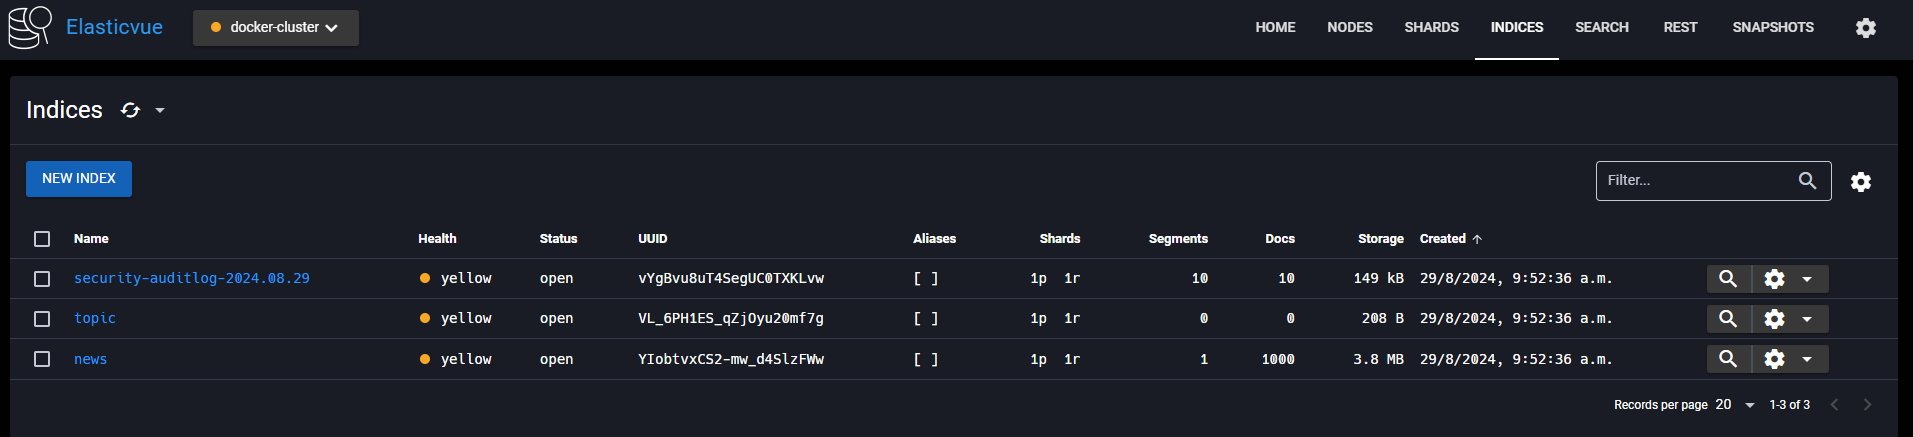

In [62]:
display(Image(filename=r'C:\Users\gabri\OneDrive\Machine Learning\Github\ITBA-NLP\images\elastivue_0.png'))